In [99]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
from tensorflow import keras

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot
import cav as cav

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

import pickle

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import scipy

In [100]:
model = load_model('v3_model.h5')

/Users/tyler/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [101]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],)

tf.logging.set_verbosity(0)

working_dir = '/home/tyler/Desktop/tcav_on_azure'
working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'


label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

In [102]:
source_dir = working_dir + '/concepts/'
activation_dir =  working_dir + '/activations/'


## Making predictions example

In [103]:
img_path = 'concepts/lots_of_zebras/img449.jpg'

img = prep2(img_path)
preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})

In [104]:
decode_predictions(preds, top=3)

[[('n02391049', 'zebra', 0.8987724),
  ('n02129604', 'tiger', 0.00087522785),
  ('n02128925', 'jaguar', 0.00075309427)]]

In [105]:
## define input image

## Save and Reload image

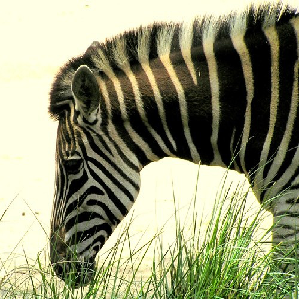

In [132]:
img_path = 'concepts/lots_of_zebras/img449.jpg'
test_img = image.load_img(img_path, target_size=(299, 299))
test_img

In [134]:
img_prep.shape

(1, 299, 299, 3)

In [135]:
img_prep = prep2(img_path)
save_img(img_prep.reshape(299,299,3), fname='results/new_test.png')

/Users/tyler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [136]:
img_path = 'results/new_test.png'
test_img = image.load_img(img_path, target_size=(299, 299))

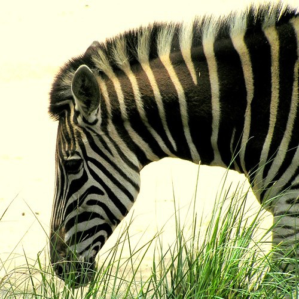

In [137]:
test_img

In [138]:
## activations at layer x

In [190]:
import os
import cav
working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'

concept = 'striped_sub_2'
cav_dict = {}
layer_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']
#layer_names = ['mixed0']
for layer_name in layer_names:
    subpath = concept + '-random500_0-' + layer_name
    cav_path = 'cav_dir/' + subpath + '-linear-0.1.pkl'
    path = os.path.join(working_dir, cav_path)
    this_cav = cav.CAV.load_cav(path)
    cav_dict[layer_name] = this_cav.cavs[0]

In [196]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
sess = K.get_session()

layer_name = 'mixed9'
acts_9 = layer_dict[layer_name].output
get_acts_9_func = K.function([model.input],[acts_9])

def get_acts(input_img):
    outs = get_acts_9_func([input_img])
    acts_value = outs[0]
    return acts_value.reshape(-1)

layer_name = 'predictions'
acts_pred = layer_dict[layer_name].output
get_preds_func = K.function([model.input],[acts_pred])

def get_preds(input_img):
    outs = get_preds_func([input_img])
    acts_value = outs[0]
    return acts_value

get_preds_func_act = K.function([layer_dict['mixed9'].output],[acts_pred])

def get_preds_from_act(act):
    outs = get_preds_func_act([act])
    acts_value = outs[0]
    return acts_value

## optimizae idx 340 for zebra
zebra_pred = np.zeros((1000,1))
zebra_pred[340] = 1

loss = K.variable(0.)

zebra_tensor = K.constant(zebra_pred)
preds = layer_dict['predictions'].output

print('zebra_tensor shape is ' + str(zebra_tensor.shape))
print('preds shape is ' + str(preds.shape))

loss += K.dot(preds,zebra_tensor)

grads = K.gradients(loss, model.input)[0]
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

outputs = [loss, grads]
fetch_loss_and_grads = K.function([model.input], outputs)

grads_acts = K.gradients(loss, layer_dict['mixed1'].output)[0]
grads_acts /= K.maximum(K.mean(K.abs(grads_acts)), K.epsilon())

outputs_acts = [loss, grads_acts]

fetch_loss_and_grads_acts = K.function([layer_dict['mixed9'].output], outputs_acts)

#fetch_loss_and_grads_acts = K.function([layer_dict['mixed9'].output], outputs_acts)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def eval_loss_and_grads_acts(x):
    outs = fetch_loss_and_grads_acts([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    acts_list = []
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        #if i % 1 == 0:
        #    print('..Loss value at', i, ':', loss_value)
        acts_list.append([get_acts(x)])
        x += step * grad_values
    return x,acts_list

def gradient_ascent_using_acts(x, iterations, step, max_loss=None):
    acts_list = []
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads_acts(x)
        if max_loss is not None and loss_value > max_loss:
            break
        if i % 1 == 0:
            print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

zebra_tensor shape is (1000, 1)
preds shape is (?, 1000)


In [185]:
img_path = 'concepts/lots_of_zebras/img449.jpg'
img_path = 'concepts/horse_sub_1/img252.jpg'
img_path = 'concepts/noise_white/img1.jpg'


In [186]:
## from activations, gradient descent to class direction
iterations = 10
step = .01
max_loss = .999


img = prep2(img_path)
orig = img.copy()

img_final = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)[0]
img_name = 'optimal'
save_img(orig.reshape(299,299,3), fname='results/orig_' + img_name + '.png')
save_img(img_final.reshape(299,299,3), fname='results/' + img_name + '.png')

/Users/tyler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


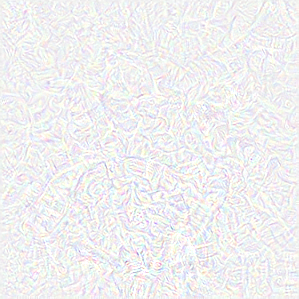

In [187]:
img_name = 'optimal'
res_path = 'results/' + img_name + '.png'
test_img = image.load_img(res_path, target_size=(299, 299))
test_img

In [188]:
img = prep2(res_path)
preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})

In [189]:
decode_predictions(preds, top=3)

[[('n03291819', 'envelope', 0.04386611),
  ('n04525038', 'velvet', 0.026705153),
  ('n02808304', 'bath_towel', 0.02639559)]]

## Find CAV

In [391]:
working_dir = '/home/tyler/Desktop/tcav_on_azure'

concept = 'striped_sub_1'

cav_dict = {}
layer_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']
for layer_name in layer_names:
    subpath = concept + '-random500_0-' + layer_name
    cav_path = 'cavs/' + subpath + '-linear-0.1.pkl'
    path = os.path.join(working_dir, cav_path)
    this_cav = cav.CAV.load_cav(path)
    cav_dict[layer_name] = this_cav.cavs[0]

In [209]:
this_cav = cav_dict['mixed9']

## Use PCA

In [203]:
pca_components = pickle.load(open('pca/pca_components_mixed9.pkl', 'rb'))

In [394]:
## from activations, gradient descent to class direction
iterations = 50
step = .01
max_loss = .99

img_path = 'concepts/striped_sub_1/striped_0004.jpg'
img = prep(img_path)
acts_orig = get_acts(img)

#img, acts_list = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)

acts_final_raw = gradient_ascent_using_acts(acts_orig.reshape(1,8,8,2048),iterations=iterations,step=step,max_loss=max_loss)
#acts_9_alt = get_acts(img)
acts_final = acts_final_raw.reshape(-1)

img_name = 'optimal'
save_img(img, fname='results/' + img_name + '.png')

..Loss value at 0 : [[0.00232409]]
..Loss value at 1 : [[0.0901473]]
..Loss value at 2 : [[0.95852894]]


/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  app.launch_new_instance()


In [216]:
#acts_final.shape

In [197]:
img_paths = ['concepts/noise_color/img1.jpg',
             'concepts/noise_color/img2.jpg',
             'concepts/noise_color/img3.jpg',
             'concepts/noise_color/img4.jpg',
             'concepts/noise_color/img5.jpg',
             'concepts/noise_color/img6.jpg',
             'concepts/noise_color/img7.jpg',
             'concepts/noise_color/img8.jpg',
             'concepts/noise_color/img9.jpg',
             'concepts/noise_color/img10.jpg',
            ]
'''
img_paths = ['concepts/random500_3/ILSVRC2012_val_00000761.JPEG',
             'concepts/random500_3/ILSVRC2012_val_00001351.JPEG',
             'concepts/random500_3/ILSVRC2012_val_00001393.JPEG',
             'concepts/random500_3/ILSVRC2012_val_00002030.JPEG',
             'concepts/random500_3/ILSVRC2012_val_00002992.JPEG',
             'concepts/random500_3/ILSVRC2012_val_00016030.JPEG',
             'concepts/random500_3/ILSVRC2012_val_00005473.JPEG',
             'concepts/random500_3/ILSVRC2012_val_00025690.JPEG',
             'concepts/random500_3/ILSVRC2012_val_00021445.JPEG',
             'concepts/random500_3/ILSVRC2012_val_00029957.JPEG',
            ]


img_paths = ['concepts/horse_sub_1/img14.jpg',
             'concepts/horse_sub_1/img121.jpg',
             'concepts/horse_sub_1/img161.jpg',
             'concepts/horse_sub_1/img186.jpg',
             'concepts/horse_sub_1/img199.jpg',
             'concepts/horse_sub_1/img198.jpg',
             'concepts/horse_sub_1/img229.jpg',
             'concepts/horse_sub_1/img236.jpg',
             'concepts/horse_sub_1/img222.jpg',
             'concepts/horse_sub_1/img182.jpg',
            ]

img_paths = ['concepts/zebra/img1001.jpg',
             'concepts/zebra/img1004.jpg',
             'concepts/zebra/img1006.jpg',
             'concepts/zebra/img1428.jpg',
             'concepts/zebra/img1427.jpg',
             'concepts/zebra/img202.jpg',
             'concepts/zebra/img1437.jpg',
             'concepts/zebra/img1324.jpg',
             'concepts/zebra/img1323.jpg',
             'concepts/zebra/img131.jpg',
            ]
'''

"\nimg_paths = ['concepts/random500_3/ILSVRC2012_val_00000761.JPEG',\n             'concepts/random500_3/ILSVRC2012_val_00001351.JPEG',\n             'concepts/random500_3/ILSVRC2012_val_00001393.JPEG',\n             'concepts/random500_3/ILSVRC2012_val_00002030.JPEG',\n             'concepts/random500_3/ILSVRC2012_val_00002992.JPEG',\n             'concepts/random500_3/ILSVRC2012_val_00016030.JPEG',\n             'concepts/random500_3/ILSVRC2012_val_00005473.JPEG',\n             'concepts/random500_3/ILSVRC2012_val_00025690.JPEG',\n             'concepts/random500_3/ILSVRC2012_val_00021445.JPEG',\n             'concepts/random500_3/ILSVRC2012_val_00029957.JPEG',\n            ]\n\n\nimg_paths = ['concepts/horse_sub_1/img14.jpg',\n             'concepts/horse_sub_1/img121.jpg',\n             'concepts/horse_sub_1/img161.jpg',\n             'concepts/horse_sub_1/img186.jpg',\n             'concepts/horse_sub_1/img199.jpg',\n             'concepts/horse_sub_1/img198.jpg',\n             'c

In [198]:
acts_orig.shape

(352800,)

In [212]:
acts_orig_array = np.zeros((len(img_paths),131072))
acts_new_array = np.zeros((len(img_paths),131072))

for i,img_path in enumerate(img_paths):
    img = prep2(img_path)
    
    acts_orig = get_acts(img)
    acts_orig_array[i] = acts_orig

    #acts_final_raw = gradient_ascent_using_acts(acts_orig.reshape(1,8,8,2048),iterations=iterations,step=step,max_loss=max_loss)
    #acts_final = acts_final_raw.reshape(-1)
    #acts_new_array[i] = acts_final

    img, acts_list = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)
    acts_new_array[i] = get_acts(img)
    

In [204]:
pca_components

array([[-0.00289557, -0.00342923, -0.00709663, ..., -0.00274066,
        -0.00697211, -0.00465672],
       [ 0.00182669, -0.0020317 ,  0.00316542, ...,  0.00092412,
        -0.00488652,  0.00149549]], dtype=float32)

In [205]:
x_orig = np.dot(pca_components, acts_orig_array.T)
x_new = np.dot(pca_components, acts_new_array.T)

In [208]:
this_cav

## Make arrows

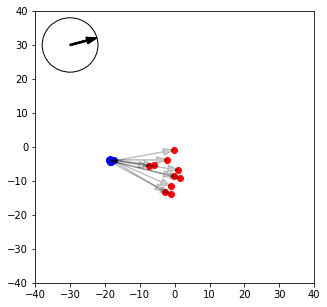

In [210]:
fig = plt.figure(figsize=[5,5])
#plt.scatter(x_list[0], x_list[1], color = 'g')

plt.scatter(x_orig[0], x_orig[1], color = 'b')
plt.scatter(x_new[0], x_new[1], color = 'r')

ax = plt.gca()

circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax.add_patch(circ)

cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vector_norm(cav_pca)
cav_norm *= 8

arrow_start = [-30,30]
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None)
ax.add_patch(my_arrow)

#new_CAV = acts_orig - acts_new
#new_cav_pca = np.dot(pca_components, new_CAV.T)
#for i in range(new_cav_pca.shape[0]):
#    new_cav_norm = vector_norm(new_cav_pca[:,i])
#    new_cav_norm *= 8
    

#circ_1 = plt.Circle((0, 30), radius=8, edgecolor='black', facecolor='None')
#ax.add_patch(circ_1)

#arrow_start = [0,30]


for i in range(x_orig.shape[1]):
    arrow_start = x_orig[:,i]
    dx,dy = x_new[:,i] - x_orig[:,i]
    
    my_arrow_3 = plt.arrow(arrow_start[0], arrow_start[1], dx, dy,width=.1,length_includes_head=True,head_width=2,fc='k', ec=None,alpha=.1)
    ax.add_patch(my_arrow_3)


#arrow_start = [x1_orig,x2_orig]
#dx,dy = x1_new - x1_orig,x2_new - x2_orig


#my_arrow_1 = plt.arrow(arrow_start[0], arrow_start[1], new_cav_norm[0], new_cav_norm[1],width=.4,
                     #length_includes_head=True,head_width=2,fc='k', ec=None)
#my_arrow_2 = plt.arrow(arrow_start[0], arrow_start[1], dx, dy,width=.1,
                     #length_includes_head=True,head_width=2,fc='k', ec=None)
#ax.add_patch(my_arrow_2)


xlim = plt.xlim([-40,40])
ylim = plt.ylim([-40,40])

#fig_path = 'figs/jul_9/pca_' + cav_name + '.png'
fig_path = 'figs/jul_12/noise_to_stripy.png'

path = os.path.join(working_dir,fig_path)
plt.savefig(path,dpi=200)


In [ ]:
acts_array = np.zeros((len(acts_list),131072))
for i,acts in enumerate(acts_list):
    if i != 0:
        acts_array[i] = acts[0].reshape(-1)
x_list = np.dot(pca_components, acts_array.T)

## Perturb

In [211]:
def pert(act,cav,alpha):
    pert_act = np.add(act, alpha * cav)
    return pert_act

In [252]:
x_orig[:,1]

array([-24.69153734, -10.81543206])

In [396]:
start_acts = acts_orig_array[0]
#acts_new_array 

In [397]:
pert_acts = pert(start_acts,this_cav,1)

In [398]:
start_acts

array([0.        , 0.57698244, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [399]:
a_orig = np.dot(pca_components, start_acts.T)
a_new = np.dot(pca_components, pert_acts.T)

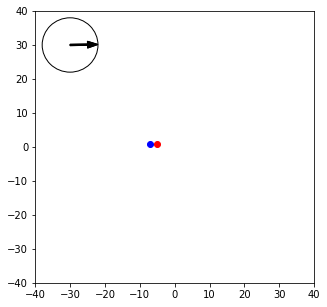

In [400]:
fig = plt.figure(figsize=[5,5])
#plt.scatter(x_list[0], x_list[1], color = 'g')

plt.scatter(a_orig[0], a_orig[1], color = 'b')
plt.scatter(a_new[0], a_new[1], color = 'r')

ax = plt.gca()

circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax.add_patch(circ)
cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vector_norm(cav_pca)
cav_norm *= 8
arrow_start = [-30,30]
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,length_includes_head=True,head_width=2,fc='k', ec=None)
ax.add_patch(my_arrow)

xlim = plt.xlim([-40,40])
ylim = plt.ylim([-40,40])

In [401]:
start_acts.mean()

0.034876432263914126

In [402]:
n = 131072
random_gen = np.random.normal(size = (n))
random_act = np.array( [a if a > 0 else 0 for a in random_gen])

In [404]:
#random_act

In [407]:
pert_acts = pert(random_act,this_cav,5)
preds = get_preds_from_act(pert_acts.reshape(1,8,8,2048))

In [408]:
decode_predictions(preds, top=3)

[[('n01930112', 'nematode', 0.0047462513),
  ('n04525038', 'velvet', 0.004522687),
  ('n03250847', 'drumstick', 0.0033154774)]]

In [409]:
img_path = 'concepts/random500_3/ILSVRC2012_val_00015808.JPEG'
img = prep(img_path)
acts_orig = get_acts(img)

In [413]:
pert_acts = pert(acts_orig,this_cav,1)
preds = get_preds_from_act(pert_acts.reshape(1,8,8,2048))

In [414]:
decode_predictions(preds, top=3)

[[('n02108915', 'French_bulldog', 0.70373833),
  ('n02093428', 'American_Staffordshire_terrier', 0.08696176),
  ('n02085620', 'Chihuahua', 0.016081117)]]

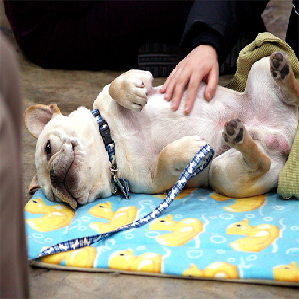

In [415]:
img_pic = image.load_img(img_path, target_size=(299, 299))
img_pic

In [417]:
this_cav.shape

(131072,)

In [418]:
b = this_cav.reshape(1,8,8,2048)

In [420]:
b.shape

(1, 8, 8, 2048)

In [421]:
b.reshape(1,5,5,2048)

ValueError: cannot reshape array of size 131072 into shape (1,5,5,2048)

In [423]:
img_path = 'concepts/random500_3/ILSVRC2012_val_00015808.JPEG'
img = prep(img_path)
img1 = img.resize((1,213,213,3))
acts_orig = get_acts(img)

ValueError: cannot resize this array: it does not own its data

In [440]:
original_img = np.copy(img)
size = (200,213,3)
shrunk = resize_img(img, size)

In [441]:
ac = get_acts(shrunk)

In [442]:
ac.shape[0]

40960

In [443]:
40960 / 2048

20.0

In [446]:
this_cav[:40960].shape

(40960,)

In [ ]:
ac.reshape()

In [7]:
def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

In [125]:
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    #if K.image_data_format() == 'channels_first':
    #    x = x.reshape((3, x.shape[2], x.shape[3]))
    #    x = x.transpose((1, 2, 0))
    #else:
    x = x.reshape((x.shape[0], x.shape[1], 3))
    #x /= 2.
    #x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def get_prediction(img):
    img = preprocess_input(img)
    preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})
    top = decode_predictions(preds, top=3)
    return top

preprocess_input

## define functions
def vector_norm(vec):
    norm_const = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
    return vec / norm_const

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

## CAV distance
def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def prep2(filename):
    shape=(299, 299)
    img = np.array(PIL.Image.open(open(filename, 'rb')).convert('RGB').resize(shape, PIL.Image.BILINEAR))
    # Normalize pixel values to between 0 and 1.
    img = np.float32(img) / 255.0
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        return None
    else:
        return np.expand_dims(img,axis=0)

In [25]:
#prep2(img_path).shape